# Finite Strain 
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/finite_strain.ipynb)

We compare small-strain and finite-strain material models for a cantilever beam subjected to a concentrated force at its tip.

In [1]:
import torch
import pyvista
import matplotlib.pyplot as plt

from torchfem import Solid
from torchfem.mesh import cube_hexa
from torchfem.materials import IsotropicElasticity3D, IsotropicSaintVenantKirchhoff3D

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Generate beam
L = 5.0
nodes, elements = cube_hexa(21, 5, 5, L, 1.0, 1.0)

# Define load
P = -10.0
tip = (nodes[:, 0] == L) & (nodes[:, 1] == 0.5) & (nodes[:, 2] == 0.5)

# Increments
t = torch.linspace(0.0, 1.0, 21)

## Reference solutions

In [2]:
# Reference time increments
t_abq = torch.linspace(0.0, 1.0, 11)

# ABAQUS displacements at the tip with linear elastic material and NLGEOM=NO
u_abq_lg = torch.tensor(
    [
        [0.00e-08, 0, -0.0000],
        [0.63e-08, 0, -0.5097],
        [1.26e-08, 0, -1.0195],
        [1.89e-08, 0, -1.5293],
        [2.52e-08, 0, -2.0391],
        [3.16e-08, 0, -2.5489],
        [3.79e-08, 0, -3.0587],
        [4.42e-08, 0, -3.5685],
        [5.05e-08, 0, -4.0782],
        [5.68e-08, 0, -4.5880],
        [6.32e-08, 0, -5.0978],
    ]
)
# ABAQUS displacements at the tip with linear elastic material and NLGEOM=YES
u_abq_ng = torch.tensor(
    [
        [-0.000, 0, -0.00000],
        [-0.029, 0, -0.50353],
        [-0.111, 0, -0.98141],
        [-0.232, 0, -1.41558],
        [-0.377, 0, -1.79791],
        [-0.536, 0, -2.12832],
        [-0.697, 0, -2.41129],
        [-0.856, 0, -2.65328],
        [-1.008, 0, -2.86087],
        [-1.152, 0, -3.03998],
        [-1.288, 0, -3.19567],
    ]
)

## Small strain isotropic elasticity without geometric non-linearity

In [3]:
material = IsotropicElasticity3D(E=1000.0, nu=0.3)
beam_lg = Solid(nodes, elements, material)

# Assign boundary conditions
beam_lg.constraints[nodes[:, 0] == 0, :] = True
beam_lg.forces[tip, 2] = P

# Solve
u_lg, _, σ_lg, F_lg, _ = beam_lg.solve(increments=t, return_intermediate=True)

# Show result
beam_lg.plot(
    u=u_lg[-1],
    element_property={"Cauchy stress": σ_lg[-1, :, 0, 0]},
    show_undeformed=True,
)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

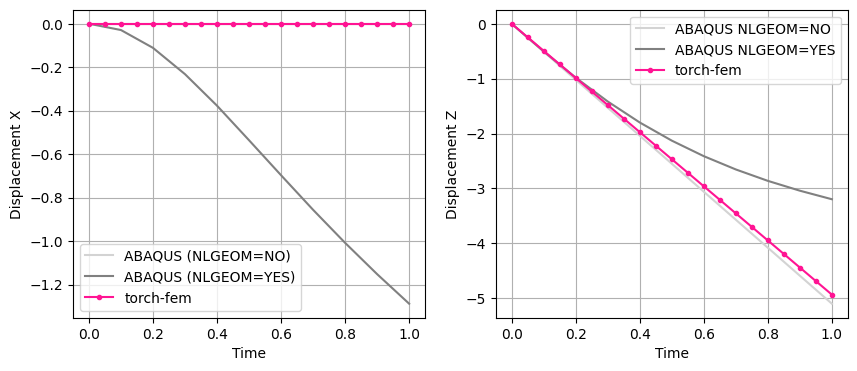

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(t_abq, u_abq_lg[:, 0], "-", color="lightgray", label="ABAQUS (NLGEOM=NO)")
ax[0].plot(t_abq, u_abq_ng[:, 0], "-", color="gray", label="ABAQUS (NLGEOM=YES)")
ax[0].plot(t, u_lg[:, tip, 0], ".-", color="deeppink", label="torch-fem")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Displacement X")
ax[0].legend()
ax[0].grid()
ax[1].plot(t_abq, u_abq_lg[:, 2], "-", color="lightgray", label="ABAQUS NLGEOM=NO")
ax[1].plot(t_abq, u_abq_ng[:, 2], "-", color="gray", label="ABAQUS NLGEOM=YES")
ax[1].plot(t, u_lg[:, tip, 2], ".-", color="deeppink", label="torch-fem")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Displacement Z")
ax[1].legend()
ax[1].grid()
plt.show()

## Isotropic Saint Venant-Kirchhoff material with geometric non-linearity

In [5]:
# Create model with Kirchhoff material
material = IsotropicSaintVenantKirchhoff3D(E=1000.0, nu=0.3)
beam_ng = Solid(nodes, elements, material)

# Assign boundary conditions
beam_ng.constraints[nodes[:, 0] == 0, :] = True
beam_ng.forces[tip, 2] = P

# Solve
u_ng, _, S_ng, _, _ = beam_ng.solve(increments=t, return_intermediate=True)

# Show result
beam_ng.plot(
    u=u_ng[-1], element_property={"PK2 Stress": S_ng[-1, :, 0, 0]}, show_undeformed=True
)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

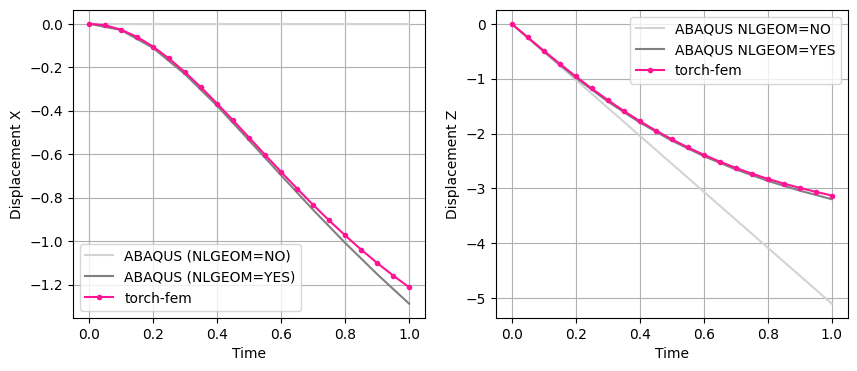

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(t_abq, u_abq_lg[:, 0], "-", color="lightgray", label="ABAQUS (NLGEOM=NO)")
ax[0].plot(t_abq, u_abq_ng[:, 0], "-", color="gray", label="ABAQUS (NLGEOM=YES)")
ax[0].plot(t, u_ng[:, tip, 0], ".-", color="deeppink", label="torch-fem")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Displacement X")
ax[0].legend()
ax[0].grid()
ax[1].plot(t_abq, u_abq_lg[:, 2], "-", color="lightgray", label="ABAQUS NLGEOM=NO")
ax[1].plot(t_abq, u_abq_ng[:, 2], "-", color="gray", label="ABAQUS NLGEOM=YES")
ax[1].plot(t, u_ng[:, tip, 2], ".-", color="deeppink", label="torch-fem")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Displacement Z")
ax[1].legend()
ax[1].grid()
plt.show()

## Comparison

In [7]:
plotter = pyvista.Plotter()
beam_lg.plot(color="gray", plotter=plotter, opacity=0.1)
beam_lg.plot(u=u_lg[-1], color="cyan", opacity=0.8, plotter=plotter)
beam_ng.plot(u=u_ng[-1], color="orange", opacity=0.8, plotter=plotter)
plotter.show(jupyter_backend="html")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…